# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment

from tqdm.notebook import tqdm
tqdm.pandas()


# 2. Load Data

In [4]:
data = pd.read_csv('../Dataset/AMZN.csv', parse_dates=['Date'])

# data = data.drop(columns=['User_ID', 'Product_ID'])
data = data.drop_duplicates().dropna()
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6531,2023-04-28,107.730003,109.480003,104.330002,105.449997,105.449997,130565000
6532,2023-05-01,104.949997,105.230003,101.820000,102.050003,102.050003,74728100
6533,2023-05-02,101.470001,103.900002,101.150002,103.629997,103.629997,73469400
6534,2023-05-03,103.739998,105.959999,103.279999,103.650002,103.650002,65051900


# 3. Initial Analysis

### 3.1. Metadata

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6536 entries, 0 to 6535
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6536 non-null   datetime64[ns]
 1   Open       6536 non-null   float32       
 2   High       6536 non-null   float32       
 3   Low        6536 non-null   float32       
 4   Close      6536 non-null   float32       
 5   Adj Close  6536 non-null   float32       
 6   Volume     6536 non-null   int32         
dtypes: datetime64[ns](1), float32(5), int32(1)
memory usage: 255.3 KB


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,6536.0,3.183160e+01,4.818578e+01,7.031300e-02,2.006063e+00,6.498250e+00,3.882175e+01,1.872000e+02
High,6536.0,3.221546e+01,4.875254e+01,7.239600e-02,2.032750e+00,6.568000e+00,3.907325e+01,1.886540e+02
Low,6536.0,3.141025e+01,4.755331e+01,6.562500e-02,1.970875e+00,6.402750e+00,3.851450e+01,1.848395e+02
Close,6536.0,3.181965e+01,4.815077e+01,6.979200e-02,2.004250e+00,6.500000e+00,3.877025e+01,1.865705e+02
Adj Close,6536.0,3.181965e+01,4.815077e+01,6.979200e-02,2.004250e+00,6.500000e+00,3.877025e+01,1.865705e+02
Volume,6536.0,1.423039e+08,1.400172e+08,9.744000e+06,6.875500e+07,1.057450e+08,1.605965e+08,2.086584e+09


In [7]:
print(f'Number of null data       : {data.isnull().sum().sum()}')
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of null data       : 0
Number of duplicates data : 0


In [8]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 3.2. Columns Processing

In [9]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Categorical Columns : []


In [10]:
def downcasting_dtypes(data):
    fcols = data.select_dtypes('float').columns
    icols = data.select_dtypes('integer').columns

    data[fcols] = data[fcols].apply(pd.to_numeric, downcast='float')
    data[icols] = data[icols].apply(pd.to_numeric, downcast='integer')

downcasting_dtypes(data)

In [ ]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()
    columns = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
    for column in columns:
        data[column] = LE.fit_transform(data[column].astype(str))
        data[column] = data[column].astype('int8')
        print(f'{column} : {LE.classes_}') 
    return data

data = change_columns_to_numerical(data)

### 3.3. EDA

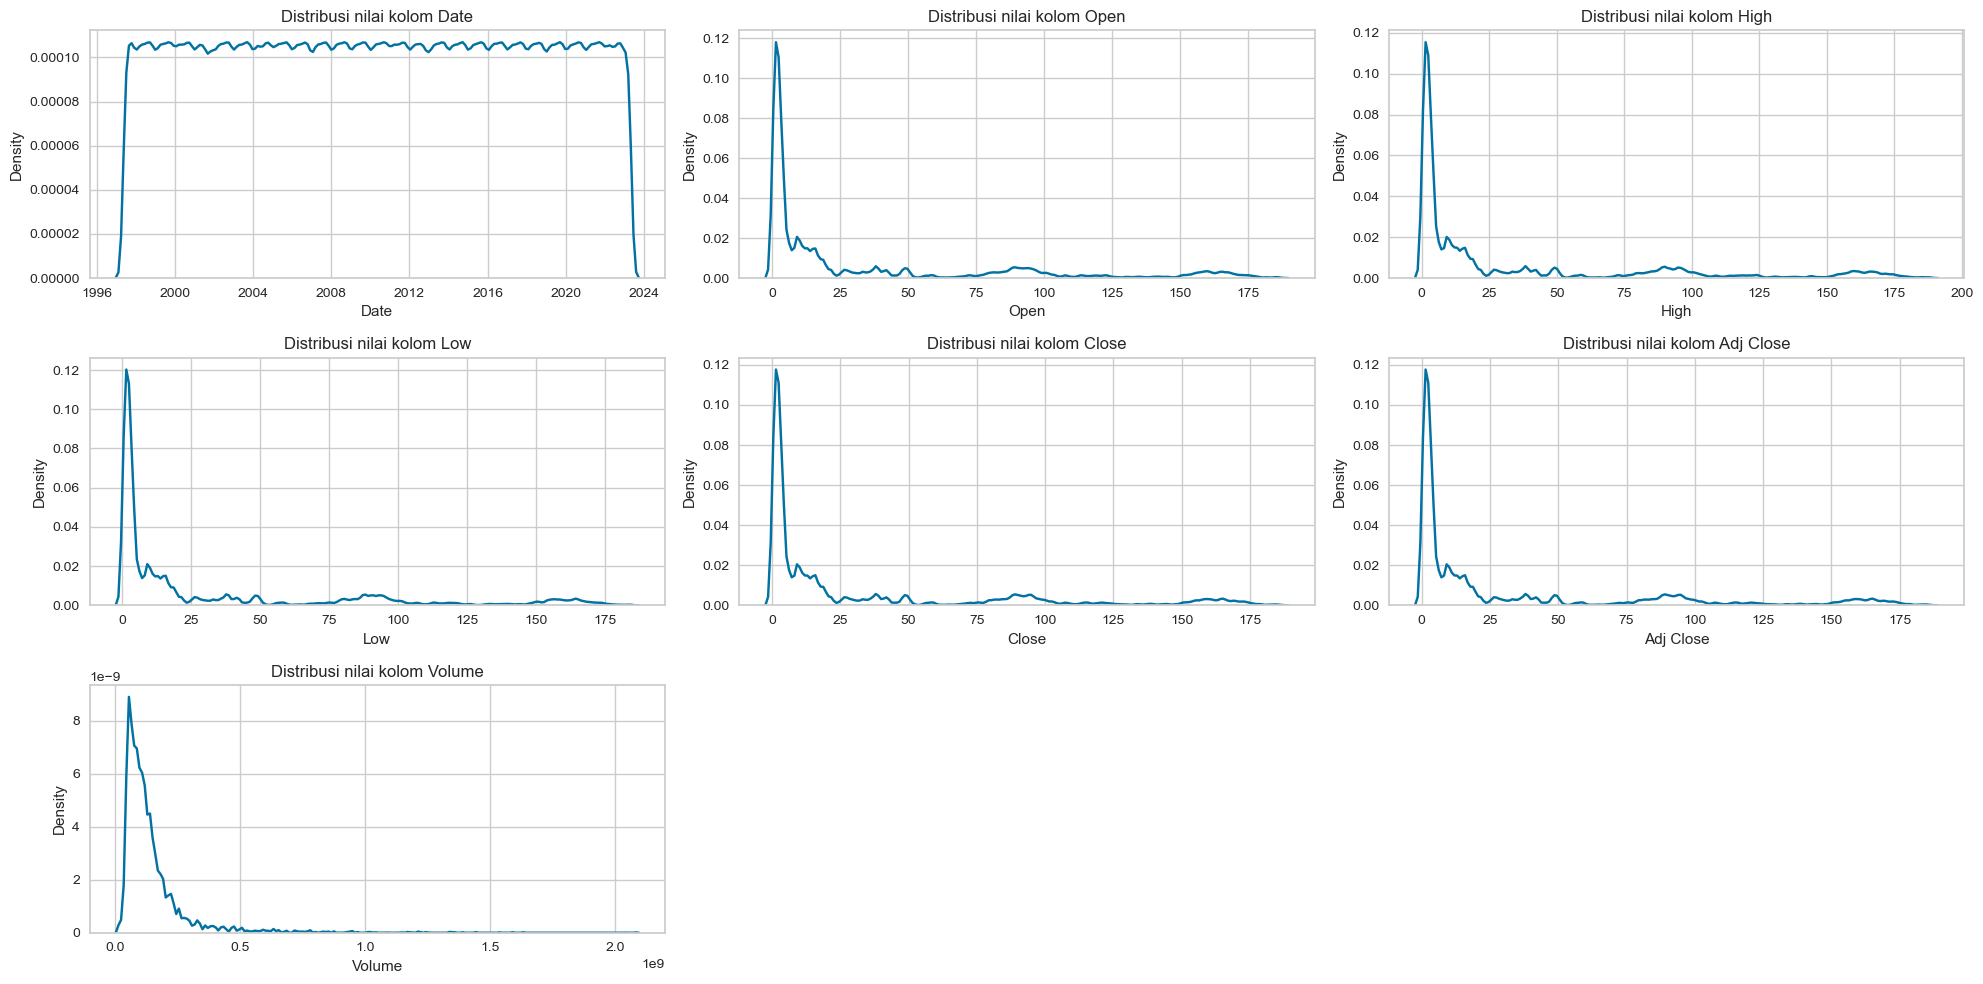

In [12]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# num_cols = 3
# num_rows = math.ceil(len(numerical_columns) / num_cols)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# for i, column in enumerate(numerical_columns):
#     row = i // num_cols
#     col = i % num_cols
#     sns.kdeplot(data=data, x=column, hue="Region", 
#                 fill=True, alpha=.2, palette="YlOrRd", 
#                 common_norm=False, ax=axes[row, col],
#                 warn_singular=False)\
#         .set_title(column)

# for i in range(len(numerical_columns), num_rows * num_cols):
#     row = i // num_cols
#     col = i % num_cols
#     axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

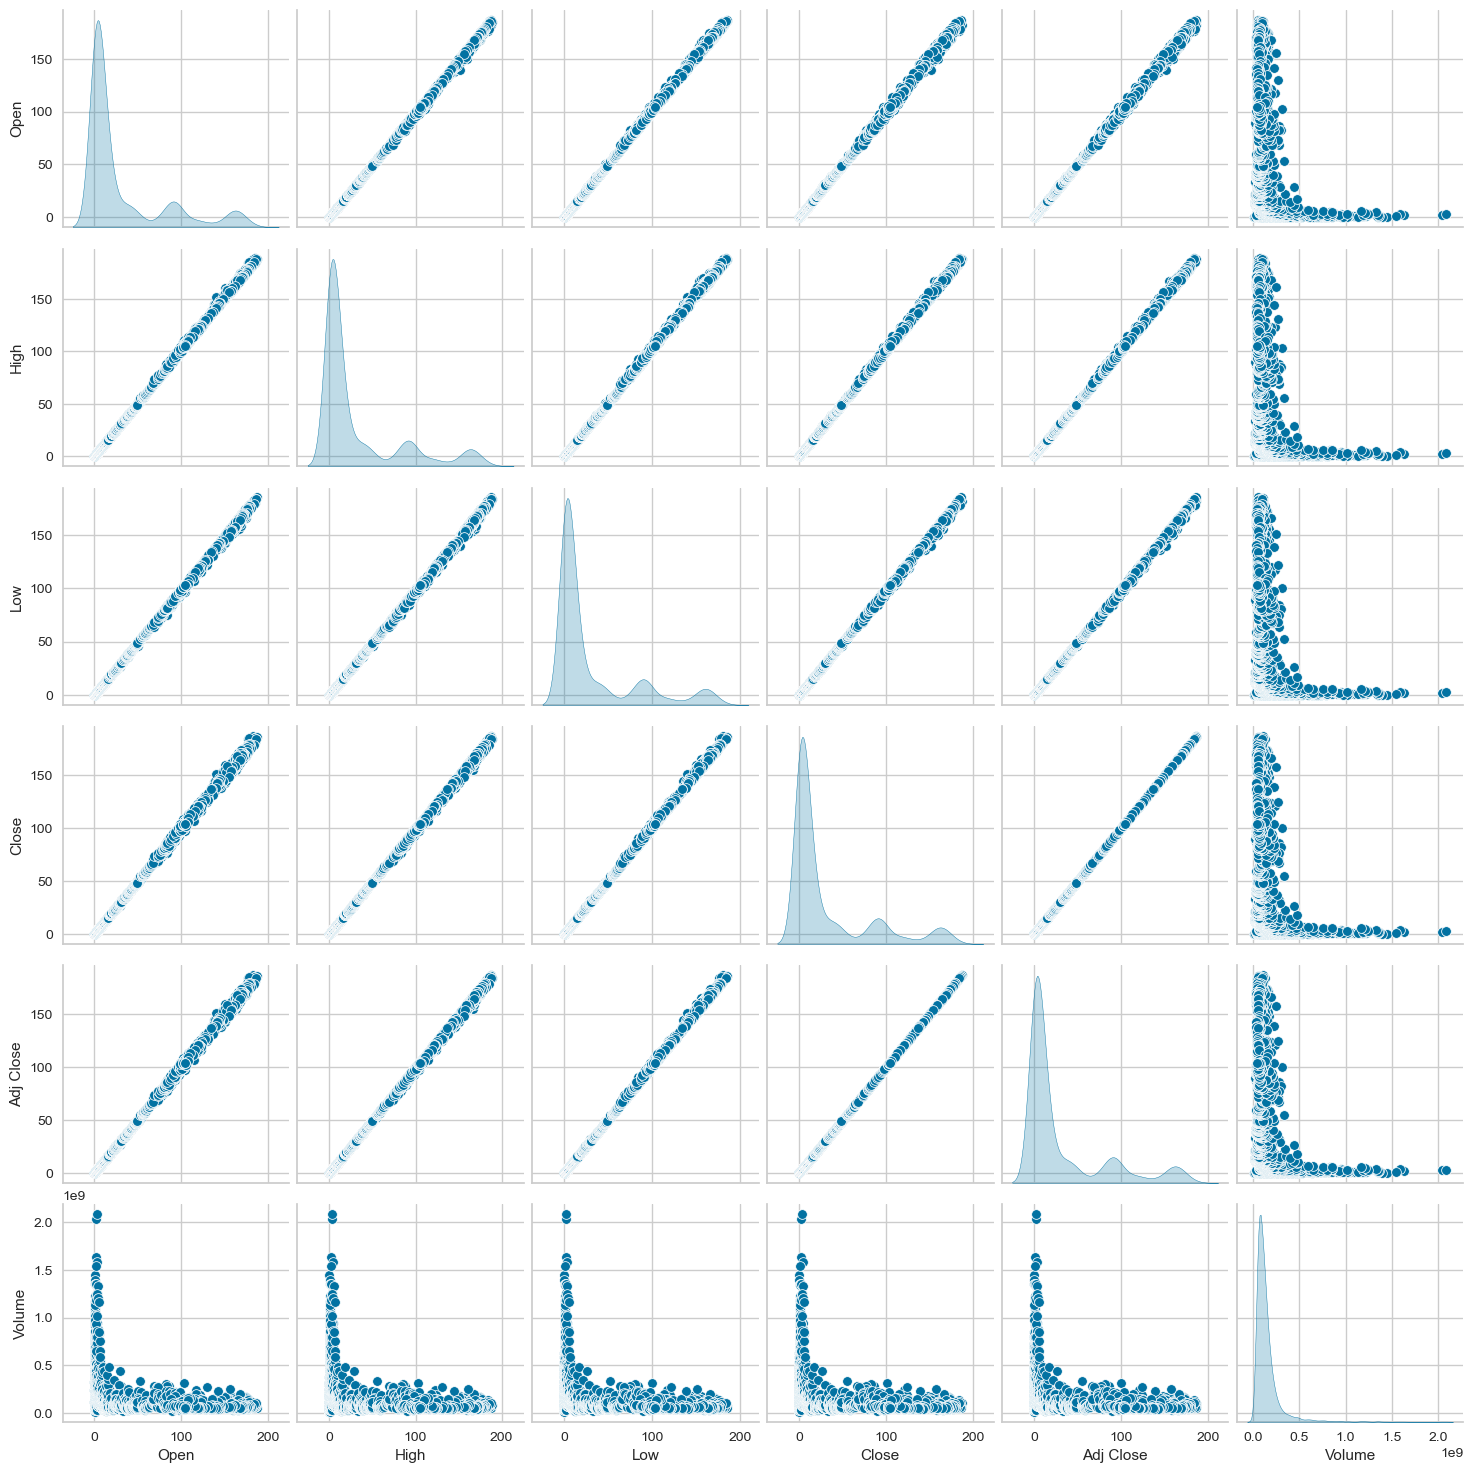

In [14]:
sns.pairplot(data, diag_kind="kde")
plt.show()

In [ ]:
# plt.subplots(figsize = (20,4))
# ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
# ax.bar_label(ax.containers[0])

In [ ]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

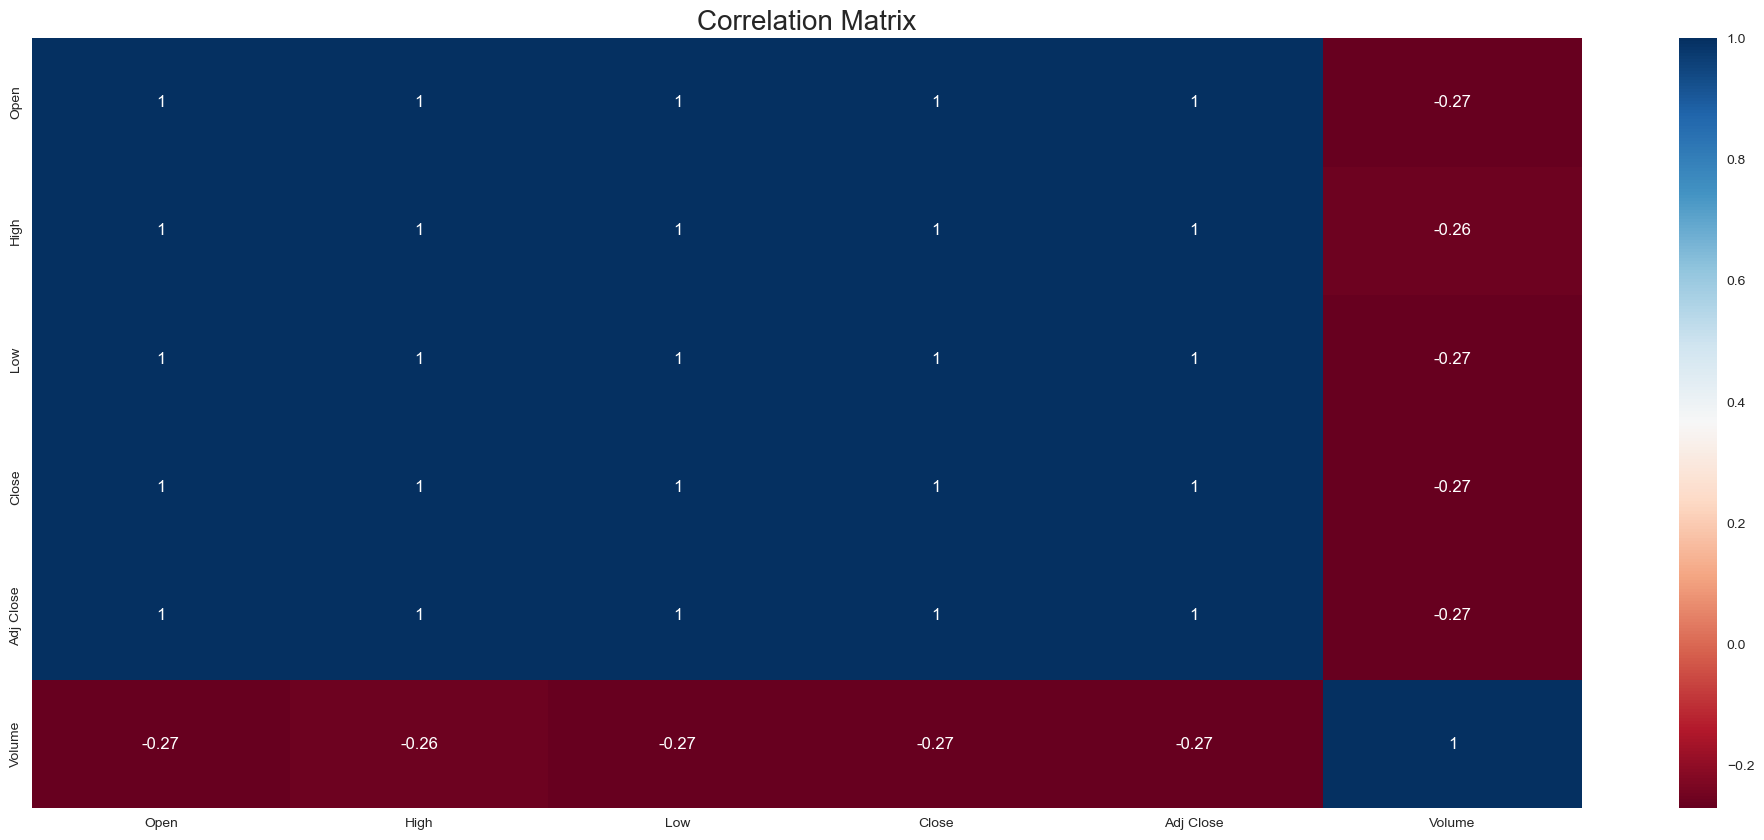

In [16]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)
plt.show()

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [59]:
X = data.drop(columns=['Close', 'Date'])
Y = data['Close']

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = RobustScaler()
# X = scaler.fit_transform(X)
# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
# X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4587, 5) (4587,)
(1295, 5) (1295,)
(654, 5) (654,)


# 5. Neural Network Algoritms

In [60]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_01)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# model.compile(loss='mae', optimizer = opt, metrics=['mae'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 5, 256)            198912    
                                                                 
 gru_7 (GRU)                 (None, 256)               394752    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 593,921
Trainable params: 593,921
Non-trainable params: 0
_________________________________________________________________


In [61]:
num_epoch = 500
batch_size = 32

history = model.fit(X_train, y_train, verbose=1,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

Epoch 1/500
144/144 [==============================] - 3s 10ms/step - loss: 3163.3269 - mse: 3163.3269 - val_loss: 2842.8315 - val_mse: 2842.8315
Epoch 2/500
144/144 [==============================] - 1s 6ms/step - loss: 2897.3564 - mse: 2897.3564 - val_loss: 2589.5466 - val_mse: 2589.5466
Epoch 3/500
144/144 [==============================] - 1s 6ms/step - loss: 2645.7917 - mse: 2645.7917 - val_loss: 2383.6951 - val_mse: 2383.6951
Epoch 4/500
144/144 [==============================] - 1s 6ms/step - loss: 2481.9604 - mse: 2481.9604 - val_loss: 2277.0815 - val_mse: 2277.0815
Epoch 5/500
144/144 [==============================] - 1s 5ms/step - loss: 2400.3376 - mse: 2400.3376 - val_loss: 2220.5757 - val_mse: 2220.5757
Epoch 6/500
144/144 [==============================] - 1s 5ms/step - loss: 2351.5422 - mse: 2351.5422 - val_loss: 2181.3267 - val_mse: 2181.3267
Epoch 7/500
144/144 [==============================] - 1s 5ms/step - loss: 2314.3538 - mse: 2314.3538 - val_loss: 2149.0132 - val

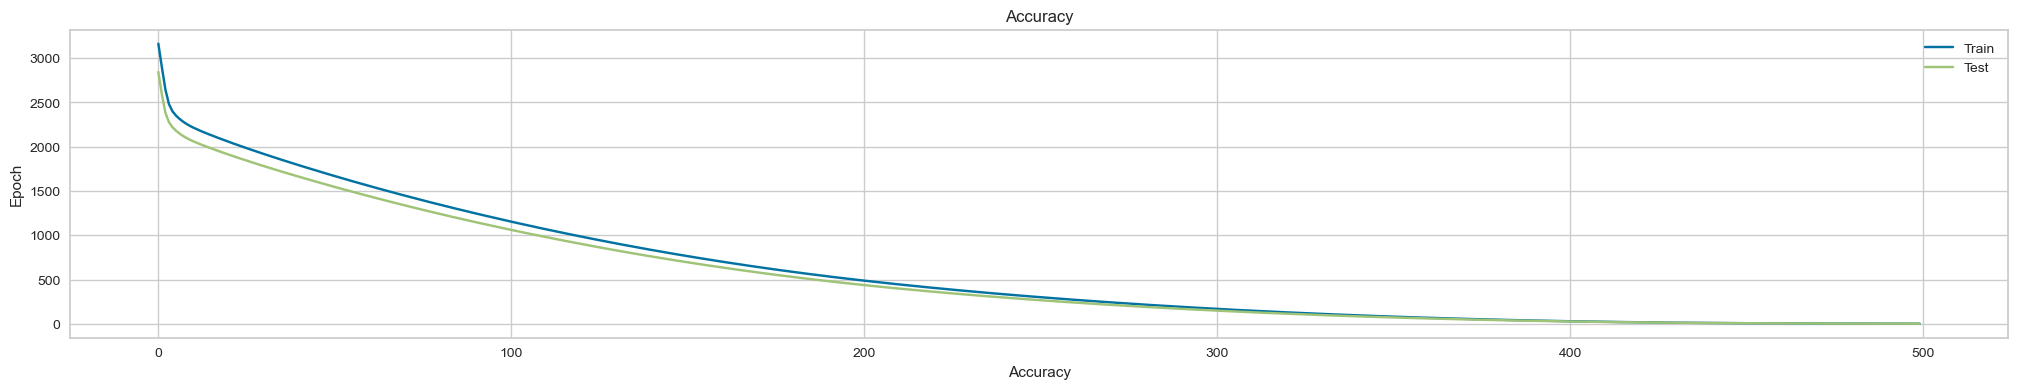

In [62]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [63]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

R Squared Error    : 1.0
Mean Squared Error : 1.22
Mean Absolute Error: 0.15


In [64]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


      Train Predictions     Actuals      Diff
3506           9.226614    9.193500  0.033114
3069           4.297041    4.249000  0.048041
4764          31.562946   31.549999  0.012947
601            3.832157    3.853125  0.020968
5870         155.972992  155.811005  0.161987
0.15159674 / 196.31778
18.361740112304688


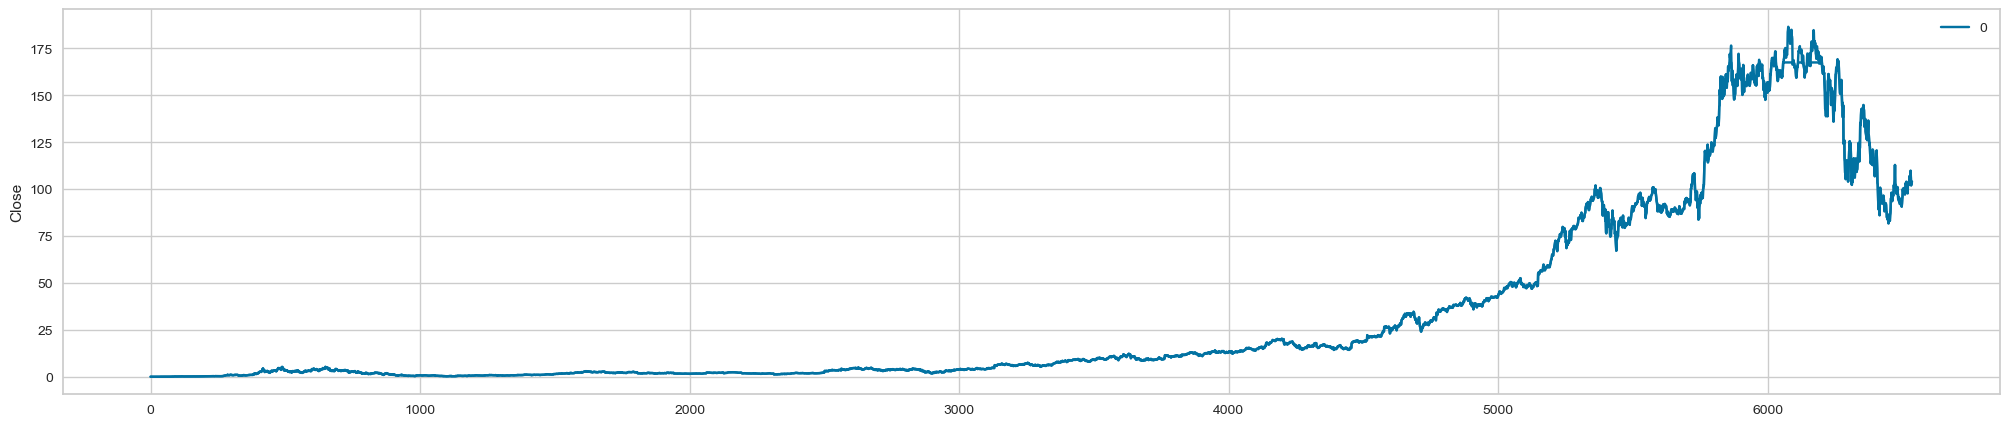

In [84]:
plt.subplots(figsize=(25,5))

features = data.drop(columns=['Close', 'Date'])

prediction = model.predict(features, verbose=0)
sns.lineplot(data['Close'])
sns.lineplot(prediction)
# plt.legend()
plt.show()

In [ ]:
data_x = data.drop(columns=['price'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = (model.predict(data_x, verbose=0)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [67]:
import optuna

def objective(trial, data = data):
    
    X = data.drop(columns=['Purchase'])
    Y = data['Purchase']

    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    scaler = PowerTransformer(method='yeo-johnson', standardize=True)
    X = scaler.fit_transform(X)

    X_train,X_test,y_train,y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
    
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000,2000,3000,4000]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    preds_valid = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds_valid, squared=False)
    return rmse

    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params

[I 2023-05-04 20:23:00,573] A new study created in memory with name: no-name-f5fe31ab-7f32-4fb2-aab0-8552a2191b51


In [85]:
best_params = {'lambda': 0.0006657878677616344, 
               'alpha': 0.04329935360636625, 
               'colsample_bytree': 1.0, 
               'subsample': 0.5, 
               'learning_rate': 0.018, 
               'n_estimators': 2000, 
               'max_depth': 11, 
               'random_state': 24, 
               'min_child_weight': 41}

adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
# model = XGBRegressor(**best_params)
XGB = XGBRegressor()
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)
linear = LinearRegression()

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    # ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
])

In [86]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                              ('XGB',
                               XGB...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_on

In [87]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')
print("Validationg Score  :",round((model.score(X_val, y_val)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

Train Score        : 100.0 %
Test Score         : 100.0 %
Validationg Score  : 100.0 %
R Squared Error    : 1.0
Mean Squared Error : 0.01
Mean Absolute Error: 0.04


In [89]:
train_predictions = (model.predict(X_test)).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))
print((train_results['Diff'].max()))


      Train Predictions     Actuals      Diff
3506           9.192586    9.193500  0.000914
3069           4.250708    4.249000  0.001708
4764          31.562852   31.549999  0.012853
601            3.851505    3.853125  0.001621
5870         155.797151  155.811005  0.013853
0.037154954388282334 / 48.11566593282562
1.7653681711375668


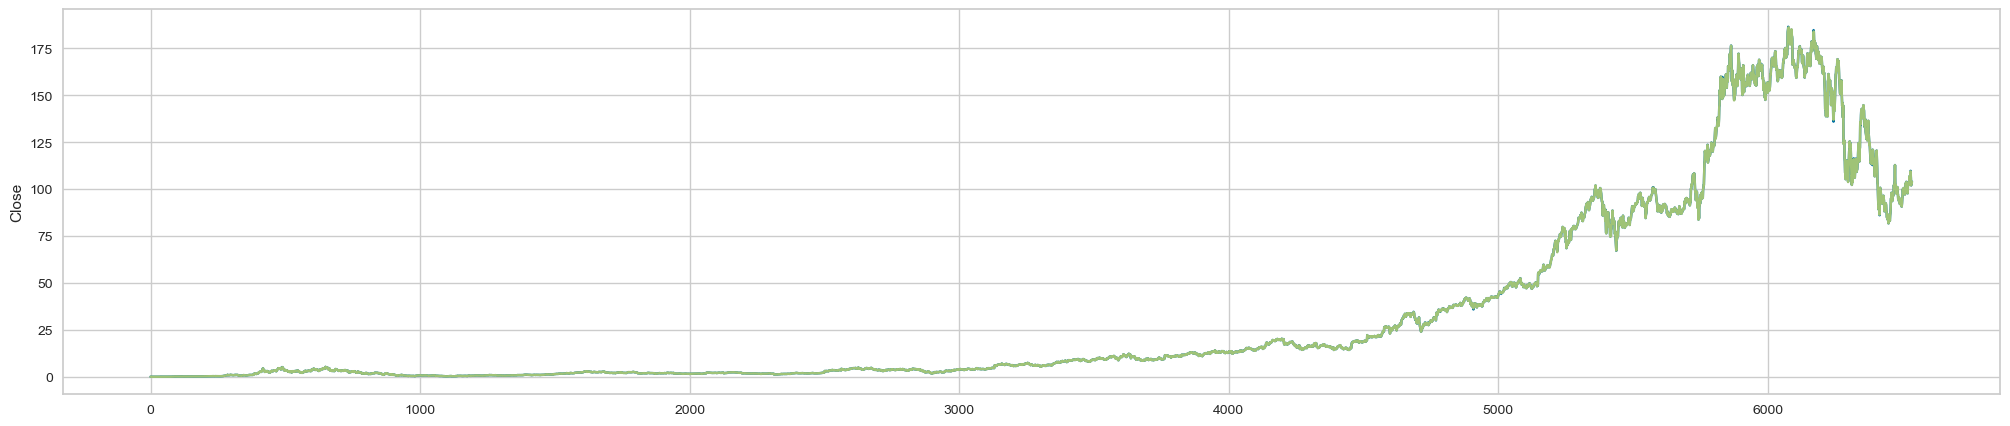

In [91]:
plt.subplots(figsize=(25,5))

features = data.drop(columns=['Close', 'Date'])

prediction = model.predict(features)
sns.lineplot(data['Close'])
sns.lineplot(prediction)
# plt.legend()
plt.show()

In [60]:
data_x = data.drop(columns=['Name', 'Overall'])

scaler = RobustScaler()
data_x = scaler.fit_transform(data_x)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data_x = scaler.fit_transform(data_x)

predictions = np.rint(model.predict(data_x)).astype(int).flatten()

data['Overall Prediction'] = pd.DataFrame(predictions)
data

,Name,Age,Nationality,Overall,Potential,Club,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,GKReflexes,Defending,General,Mental,Passing,Mobility,Power,Shooting,Rating,Overall Prediction
0,L. Messi,31,6,94,94,212,0,5.0,4.0,4.0,...,8.0,29,89,71,87,91,74,88,94,94
1,Cristiano Ronaldo,33,123,94,94,326,1,5.0,4.0,5.0,...,11.0,27,88,73,81,91,83,88,94,94
2,Neymar Jr,26,20,92,93,436,1,5.0,5.0,5.0,...,11.0,28,85,72,80,94,69,84,92,92
3,De Gea,27,139,91,93,375,1,4.0,3.0,1.0,...,94.0,16,26,43,39,66,54,21,92,89
4,K. De Bruyne,27,13,91,92,374,1,4.0,5.0,4.0,...,13.0,59,79,81,92,81,76,85,92,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,46,47,65,165,1,1.0,2.0,2.0,...,9.0,45,39,46,43,55,54,37,56,47
18203,N. Christoffersson,19,144,47,63,588,1,1.0,2.0,2.0,...,12.0,19,41,37,30,40,52,39,55,47
18204,B. Worman,16,46,47,67,122,1,1.0,3.0,2.0,...,13.0,19,43,36,30,59,51,42,57,47
18205,D. Walker-Rice,17,46,47,66,587,1,1.0,3.0,2.0,...,9.0,24,44,38,39,48,50,45,56,48


### 6.2. Pycarets

In [37]:
s = RegressionExperiment()
s.setup(data, target = 'Item_Outlet_Sales', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Item_Outlet_Sales
2,Target type,Regression
3,Original data shape,"(1705, 37)"
4,Transformed data shape,"(1705, 37)"
5,Transformed train set shape,"(1193, 37)"
6,Transformed test set shape,"(512, 37)"
7,Numeric features,36
8,Preprocess,True
9,Imputation type,simple


In [38]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:30:58
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


HuberRegressor()


In [ ]:
s.evaluate_model(best)

In [39]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,590.1542,797415.2204,892.9811,0.7127,0.4866,0.4199


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Overall Prediction,Item_Outlet_Sales,prediction_label
1134,12.150000,0.021757,165.018402,1999,0,1,0,0,0,0,...,1,0,0,0,1,0,0,2658,3302.367920,2684.177348
249,9.800000,0.141406,50.000801,2007,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1643,506.007996,1572.491272
1143,6.135000,0.079327,152.836594,1997,0,0,1,0,0,1,...,1,0,0,0,1,0,0,2648,2871.595459,2468.206772
809,12.911574,0.124300,73.469597,1985,0,1,0,0,0,0,...,1,0,0,1,0,0,0,313,298.278412,381.094023
657,6.920000,0.038447,63.585201,2004,0,1,0,0,0,0,...,0,1,0,0,1,0,0,883,751.022400,950.244089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,17.200001,0.025162,145.941803,2004,0,0,1,0,0,0,...,0,1,0,0,1,0,0,2694,1765.701660,2689.931096
1688,9.800000,0.026895,128.401993,2002,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1637,2403.538086,1719.376834
1612,16.000000,0.173463,157.697205,2009,0,0,1,0,0,0,...,0,0,1,0,0,1,0,2359,2960.146729,2184.149560
954,9.800000,0.013830,45.306000,1987,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1388,1304.968018,1318.843237
